# Control your PC with gestures !
# Imports

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import time

# Loading the data

In [2]:
#Contains 3 folders A,B and nothing
train_dir="im"
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 15
# Validation set size
valid_size= 0.1

# Testing set size
test_size = 0.1

# TODO: Define your transforms for the training and validation sets

train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.ColorJitter(brightness=0.3,saturation=0.2), #Randomly change brightness and saturation
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(train_dir, transform=test_transforms)
test_data = datasets.ImageFolder(train_dir,transform = test_transforms)


#Validation portion 
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)


train_split = int(np.floor((valid_size+test_size) * num_train))
TRAIN_IDX, valid_test_idx = indices[train_split:], indices[:train_split]


num_valid_test = len(valid_test_idx)
valid_split = int (np.floor((valid_size/(valid_size+test_size))* num_valid_test))
VALID_IDX, TEST_IDX= valid_test_idx[:valid_split] , valid_test_idx[valid_split:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(TRAIN_IDX)
valid_sampler = SubsetRandomSampler(VALID_IDX)
test_sampler = SubsetRandomSampler(TEST_IDX)

# TODO: Using the image datasets and the trainforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers)

print("Training size : ",len(train_loader.dataset))
print("Validation size : ",len(valid_loader))
print("Validation size : ",len(test_loader))
print(train_data.class_to_idx)


Training size :  432
Validation size :  3
Validation size :  3
{'A': 0, 'B': 1, 'nothing': 2}


# Creating the model
## Use a Desenet161 pretrained model

In [3]:
model = models.densenet161(pretrained=True)

D:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create the classifier part

In [5]:
# TODO: Build your network
#Freezing the parameters
for param in model.parameters():
    param.requires_grad = False

class Network(nn.Module):
  def __init__(self,n_hidden1=1024,n_hidden2=512,number_of_signs=3):
    super().__init__()
    
    self.fc1=nn.Linear(2208,n_hidden1)
    self.relu1=nn.ReLU()
    self.fc2=nn.Linear(n_hidden1,n_hidden2)
    self.relu2=nn.ReLU()
    self.output=nn.Linear(n_hidden2,number_of_signs)
    self.dropout=nn.Dropout(p=0.25)
    
  def forward(self,x):
    
    x=self.relu1(self.fc1(x))
    x=self.dropout(x)
    x=self.relu2(self.fc2(x))
    x=self.dropout(x)
    x=self.output(x)
    
    return x
  
model.classifier=Network()
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

## Useful functions for saving/loading data and getting Learning rate

In [6]:

def save_model(model,minimum_loss,filename):
  state=model.state_dict()
  torch.save({"minloss":minimum_loss,"state":state},filename)
  
def load_model(filename):
  return torch.load(filename)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Training function

In [7]:
def trainCEL(model,n_epochs,train_loader,valid_loader,learning_rate=0.01,opt="SGD",cont=False,modelPath=None,freeze=True,N_EPOCHS_TO_UNFREEZE=30):
  minimum_loss=np.inf
  #In the case i want to continue training a saved model.
  if(cont):
    chpt=load_model(modelPath)
    model.load_state_dict(chpt["state"])
    minimum_loss=chpt["minloss"]
  
  #To freeze/unfreeze parameters while training to fine tune the model.
  parameters_to_train = model.classifier.parameters()
  if freeze:
    for param in model.parameters():
      param.requires_grad = False
    for param in model.classifier.parameters():
      param.requires_grad = True
  else:
    for param in model.parameters():
      param.requires_grad = True
    parameters_to_train=model.parameters()
      
      
      
  criterion = nn.CrossEntropyLoss()
  if opt=="Adam":
    optimizer=optim.Adam(parameters_to_train,lr=learning_rate)
  elif opt=="SGD":
    optimizer=optim.SGD(parameters_to_train,lr=learning_rate,momentum=0.9)
    
  #Scheduler for LR
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  model.train()
  #For plotting losses, accuracy and LR
  plot_training_loss=[]
  plot_validation_loss=[]
  plot_accuracy=[]
  plot_lr=[]
    
  #For calculating the elapsed time
  startTime=time.time()
  for e in range(n_epochs):
    #For freezeing while training
    if not freeze:
      #If i arrived at the number of epochs i wanted to wait for before freezing the features part
      if((e+1)==N_EPOCHS_TO_UNFREEZE):
        #Freeze all the network
        for param in model.parameters():
          param.requires_grad = False
        #Unfreeze classifier part
        for param in model.classifier.parameters():
          param.requires_grad = True
        #Instantiate a new optimizer with the new unfrozen parameters
        if opt=="Adam":
          optimizer=optim.Adam(model.classifier.parameters(),lr=learning_rate)
        elif opt=="SGD":
          optimizer=optim.SGD(model.classifier.parameters(),lr=learning_rate,momentum=0.9)
      
      
    running_loss=0
    step=0
    startEpoch=time.time()
    for images,labels in train_loader:
      #move variables to GPU
      images,labels = images.to(device),labels.to(device)

      optimizer.zero_grad()
      #forward
      output=model(images)
      #calculate loss
      loss=criterion(output,labels)
      #backpropagate
      loss.backward()
      #update weights
      optimizer.step()
      #accumulate loss
      running_loss+=loss.item()
      step+=1
      if(step%25 ==0):
        print(f"Epoch {e+1} , Batch {step}/{len(train_loader)} Loss:{loss} Running time Epoch: {time.time()-startEpoch:.3f} s, Running Time: {time.time()-startTime:.3f} s")

    running_loss/=len(train_loader)
    #add to the list to plot
    plot_training_loss.append(running_loss)
    
    #Validation part 
    validation_loss=0
    accuracy=0

    #turn model to eval mode
    model.eval()
    with torch.no_grad():
        for images,labels in valid_loader:
          #move variables to GPU
          images,labels = images.to(device),labels.to(device)

          #forward
          output=model(images)
          #calculate loss
          loss=criterion(output,labels)

          #calculate validation loss 
          validation_loss+=loss.item()
          #calculate accuracy
          ps=F.softmax(output,dim=1)
          top_p,top_c= ps.topk(1,dim=1)
          equals= labels == top_c.view(*labels.shape)
          accuracy+= equals.type(torch.FloatTensor).mean()


        validation_loss/=len(valid_loader)
        accuracy/=len(valid_loader)
        #add to the list to plot
        
        
        #Make a scheduler step
        scheduler.step(validation_loss)
        
        plot_validation_loss.append(validation_loss)
        
        plot_lr.append(get_lr(optimizer))
        
        plot_accuracy.append(accuracy)
        
        better=False
        if validation_loss<minimum_loss:
          minimum_loss=validation_loss
          save_model(model,minimum_loss,"net_signs.pt")
          better=True
    #turn model to train mode
    model.train()
    print(f"======>Epoch {e+1} Finished , TLoss:{running_loss} VLoss :{validation_loss} Accuracy : {accuracy} Better : {better} Time taken: {time.time() -startEpoch}")
    
    #Plot to follow training progress
    ax=plt.figure()
    t=ax.add_subplot(3,1,1)
    t.plot(plot_validation_loss,label="Validation loss")
    t.plot(plot_training_loss,label="Training loss")
    plt.legend()

    v=ax.add_subplot(3,1,2)
    v.plot(plot_accuracy,label="Accuracy")
    plt.legend()
    
    l=ax.add_subplot(3,1,3)
    l.plot(plot_lr,label="Learning Rate")
    
    plt.legend()
    plt.show()

## Training the network for 20 Epochs with LR 0.001 sing SGD

======>Epoch 1 Finished , TLoss:1.1022930244604747 VLoss :1.1186024347941081 Accuracy : 0.2290598303079605 Better : True Time taken: 19.377788066864014


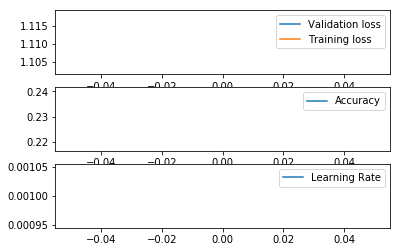

======>Epoch 2 Finished , TLoss:1.0849755729238193 VLoss :1.098222295443217 Accuracy : 0.2358974665403366 Better : True Time taken: 18.276551485061646


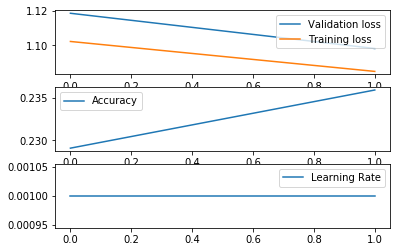

======>Epoch 3 Finished , TLoss:1.0846237689256668 VLoss :1.1029397249221802 Accuracy : 0.2290598303079605 Better : False Time taken: 18.43239140510559


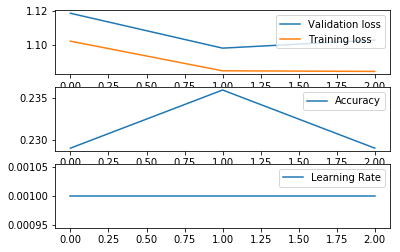

======>Epoch 4 Finished , TLoss:1.0630853722492855 VLoss :1.0752970377604167 Accuracy : 0.26153847575187683 Better : True Time taken: 18.348156690597534


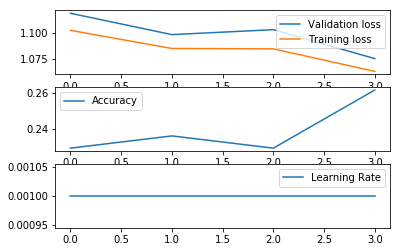

======>Epoch 5 Finished , TLoss:1.0553109049797058 VLoss :1.0635161399841309 Accuracy : 0.5094017386436462 Better : True Time taken: 18.121944189071655


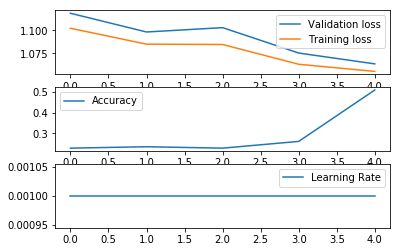

======>Epoch 6 Finished , TLoss:1.045363148053487 VLoss :1.0431573589642842 Accuracy : 0.41025641560554504 Better : True Time taken: 18.282291173934937


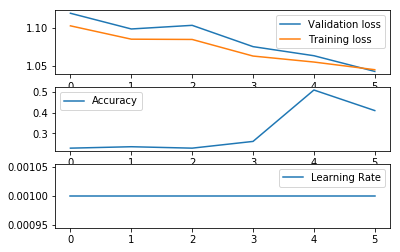

======>Epoch 7 Finished , TLoss:1.0159710794687271 VLoss :1.0156360268592834 Accuracy : 0.6051282286643982 Better : True Time taken: 18.504151344299316


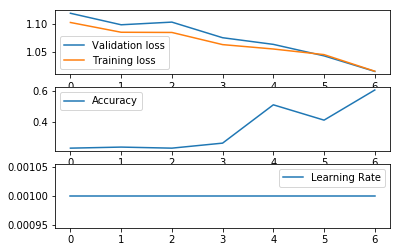

======>Epoch 8 Finished , TLoss:1.0104634488622348 VLoss :0.9881886641184489 Accuracy : 0.5162393450737 Better : True Time taken: 18.399255752563477


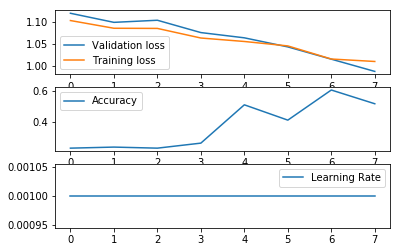

======>Epoch 9 Finished , TLoss:0.9704853172103564 VLoss :0.9429714878400167 Accuracy : 0.7675213813781738 Better : True Time taken: 18.16736912727356


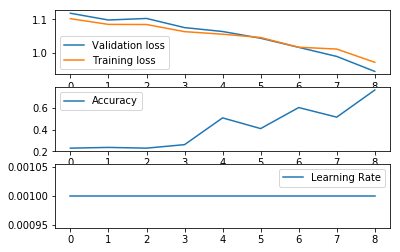

======>Epoch 10 Finished , TLoss:0.927877776324749 VLoss :0.8914546171824137 Accuracy : 0.8341880440711975 Better : True Time taken: 18.834068775177002


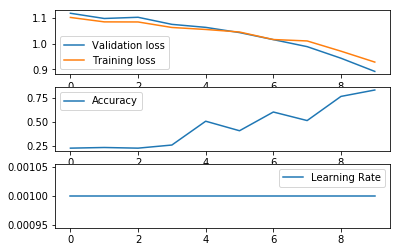

======>Epoch 11 Finished , TLoss:0.9035204872488976 VLoss :0.8241140643755595 Accuracy : 0.8786324858665466 Better : True Time taken: 18.971492052078247


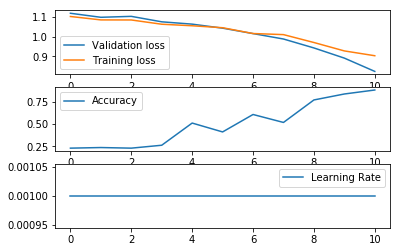

======>Epoch 12 Finished , TLoss:0.8681468963623047 VLoss :0.7895192305246989 Accuracy : 0.7863247990608215 Better : True Time taken: 18.737366676330566


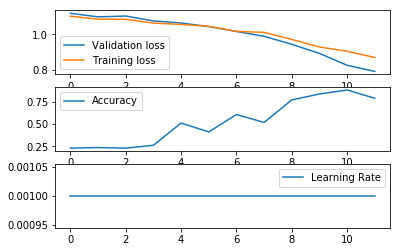

======>Epoch 13 Finished , TLoss:0.782102939983209 VLoss :0.7454553643862406 Accuracy : 0.6940171122550964 Better : True Time taken: 18.65808868408203


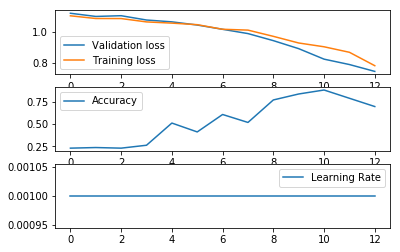

======>Epoch 14 Finished , TLoss:0.7773273264368376 VLoss :0.7516643206278483 Accuracy : 0.7487179636955261 Better : False Time taken: 17.87509059906006


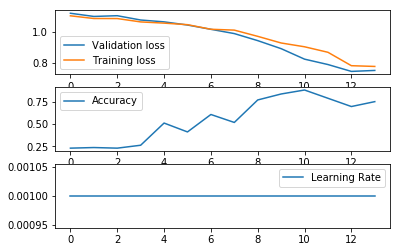

======>Epoch 15 Finished , TLoss:0.7331019540627798 VLoss :0.5792916615804037 Accuracy : 0.8854700922966003 Better : True Time taken: 18.51923966407776


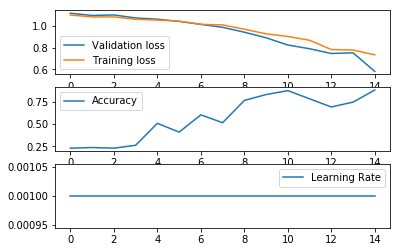

======>Epoch 16 Finished , TLoss:0.646018460392952 VLoss :0.5300376216570536 Accuracy : 0.7709401249885559 Better : True Time taken: 18.90605902671814


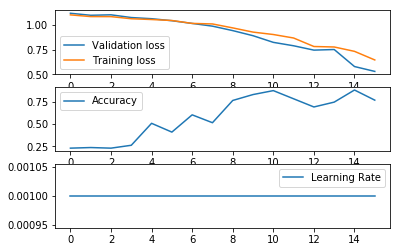

======>Epoch 17 Finished , TLoss:0.750481424232324 VLoss :0.4854887028535207 Accuracy : 0.8820512890815735 Better : True Time taken: 19.302571296691895


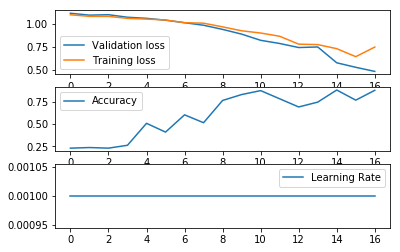

======>Epoch 18 Finished , TLoss:0.6210121971865495 VLoss :0.5735233326752981 Accuracy : 0.8188033699989319 Better : False Time taken: 18.44143581390381


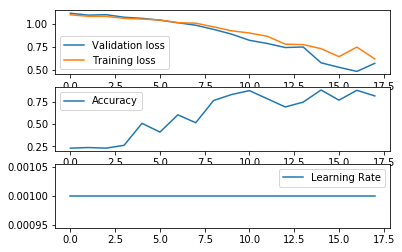

======>Epoch 19 Finished , TLoss:0.6386860509713491 VLoss :0.46717233459154767 Accuracy : 0.8051281571388245 Better : True Time taken: 18.702024221420288


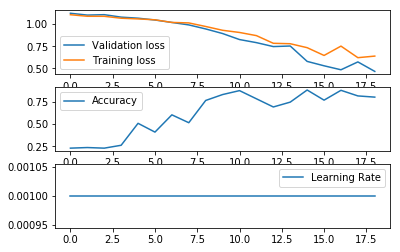

======>Epoch 20 Finished , TLoss:0.5945353346566359 VLoss :0.4201888342698415 Accuracy : 0.8341880440711975 Better : True Time taken: 18.843188047409058


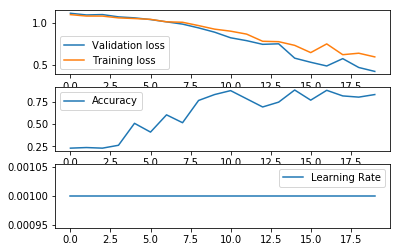

In [8]:
trainCEL(model,20,train_loader,valid_loader,learning_rate=0.001,opt="SGD")

## Loading the best model saved in "net.pt"
Ps : This is not the version of the checkpoint i'm giving in github 

In [9]:
chpt=load_model("net_signs.pt")
model.load_state_dict(chpt["state"])
minimum_loss=chpt["minloss"]
print("Validation Loss : " ,minimum_loss)

Validation Loss :  0.4201888342698415


## Testing the model

In [14]:
testing_loss=0
testing_accuracy=0
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  for images,labels in test_loader:
    #move variables to GPU
    images,labels = images.to(device),labels.to(device)

    #forward
    output=model(images)
    #calculate loss
    loss=criterion(output,labels)

    #calculate validation loss 
    testing_loss+=loss.item()
    #calculate accuracy
    ps=F.softmax(output,dim=1)
    top_p,top_c= ps.topk(1,dim=1)
    equals= labels == top_c.view(*labels.shape)
    testing_accuracy+= equals.type(torch.FloatTensor).mean()


  testing_loss/=len(test_loader)
  testing_accuracy/=len(test_loader)

print(f"Testing Loss : {testing_loss} Testing_accuracy : {testing_accuracy}")

Testing Loss : 0.2734617392222087 Testing_accuracy : 0.9777777791023254


## Getting the index to class variable to get back to folder names

In [15]:
idx_to_class= { value:key for key,value in train_data.class_to_idx.items()}
idx_to_class

{0: 'A', 1: 'B', 2: 'nothing'}

## Showing the testing accuracy per class

In [17]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
train_on_gpu=True
criterion= nn.CrossEntropyLoss()
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %2d %5s: %2d%% (%2d/%2d)' % (i+1,
            idx_to_class[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (idx_to_class[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.027437

Test Accuracy of  1     A: 92% (12/13)
Test Accuracy of  2     B: 100% (14/14)
Test Accuracy of  3 nothing: 100% (16/16)

Test Accuracy (Overall): 97% (42/43)
